# Explore and process the South America gravity data

## Package imports

In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import seaborn  # Makes the default style of the plots nicer

In [3]:
from fatiando.gravmag import tesseroid, normal_gravity
from fatiando import gridder, utils
import fatiando

In [4]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 3aed3f5676a45705b598bfc72f9883043097c854


In [5]:
from tesseroid_mesh import TesseroidRelief
from datasets import fetch_crust1, load_icgem_gdf

In [6]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 4


## Load and plot the data

In [7]:
data = load_icgem_gdf('../data/goco05s-sam-s0.1deg-h50km.gdf')

The data is return in a Python dictionary. The following fields are read from the file:

In [8]:
print(data.keys())

['area', 'longitude', 'height', 'shape', 'latitude', 'gravity_ell', 'metadata']


`metadata` is the file header.

In [9]:
print(data['metadata'])

generating_institute     gfz-potsdam
     generating_date     2015/08/13
        product_type     gravity_field
                body     earth
           modelname     goco05s
     max_used_degree           280
         tide_system     zero_tide
          functional     gravity_ell  (centrifugal term included)
                unit     mgal
          refsysname     WGS84
            gmrefpot      3.98600441800E+14 m**3/s**2
        radiusrefpot     6378137.000 m
          flatrefpot      3.352810664747480E-03   (1/298.25722356300)
         omegarefpot      7.29211500000E-05 1/s
       long_lat_unit     degree
      latlimit_north       20.000000000000    
      latlimit_south      -60.000000000000    
      longlimit_west       270.00000000000    
      longlimit_east       330.00000000000    
            gridstep      0.10000000000000    
     height_over_ell      50000.0000 m
  latitude_parallels           801
 longitude_parallels           601
number_of_gridpoints        481401
     

Unpack the data from the dictionary into variables for easier manipulation.

In [10]:
lat, lon, height, grav = data['latitude'], data['longitude'], data['height'], data['gravity_ell']
area = data['area']
print("Data area (S, N, W, E): {}".format(area))
shape = data['shape']
print("Number of points in latitude and longitude: {}".format(shape))

Data area (S, N, W, E): [-60.0, 20.0, 270.0, 330.0]
Number of points in latitude and longitude: (801, 601)


Setup a [basemap](http://matplotlib.org/basemap/index.html) to plot the data with an appropriate projection.

In [11]:
bm = Basemap(projection='cyl', 
             llcrnrlon=area[2], urcrnrlon=area[3], llcrnrlat=area[0], urcrnrlat=area[1],
             lon_0=0.5*(area[2] + area[3]), lat_0=0.5*(area[1] + area[0]), 
             resolution='l')

Make a plotting function to avoid repeating this code.

In [29]:
def plot_data(lat, lon, data, shape, cmap, cblabel='mGal', levels=60, ranges=True):
    x, y = bm(lon, lat) # Transform lat and lon into plot coordinates
    kwargs = dict(cmap=cmap)
    if ranges:
        ranges = np.abs([data.min(), data.max()]).max()
        kwargs['vmin'] = -ranges
        kwargs['vmax'] = ranges
    fig = plt.figure(figsize=(7, 6))
    bm.contourf(x.reshape(shape), y.reshape(shape), data.reshape(shape), levels, **kwargs)
    plt.colorbar(pad=0.01, aspect=50).set_label(cblabel)
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    bm.drawcoastlines(color="#333333")
    plt.tight_layout(pad=0)
    return fig

Plot the raw gravity data.

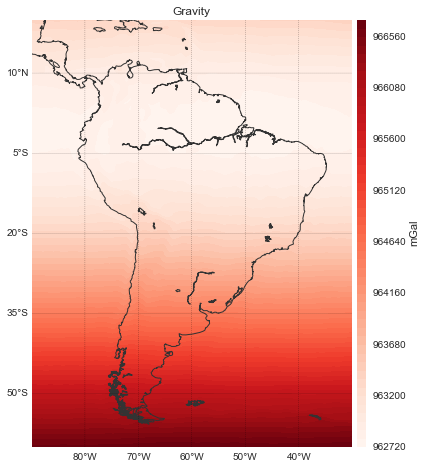

In [30]:
plot_data(lat, lon, grav, shape, 'Reds', ranges=False)
plt.title('Gravity')

## Calculate gravity disturbance

In [27]:
disturbance = grav - normal_gravity.gamma_closed_form(lat, height)

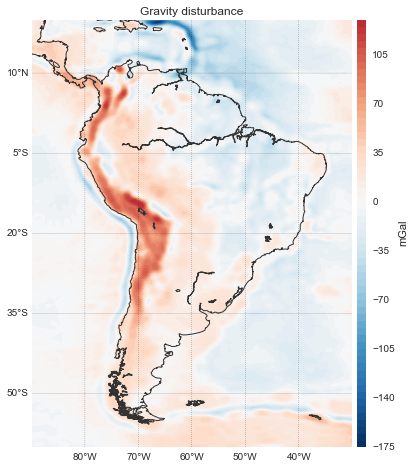

In [28]:
plot_data(lat, lon, disturbance, shape, 'RdBu_r')
plt.title('Gravity disturbance')

## Terrain correction

In [16]:
topo_data = load_icgem_gdf('../data/topography-sam-s0.1deg.gdf', usecols=[-1])

In [17]:
print(topo_data['metadata'])

generating_institute     gfz-potsdam
     generating_date     2015/08/14
        product_type     topography
                body     earth
           modelname     etopo1_bin_int
          functional     topography_grd (grid)=>bi-linear interpolation
                unit     meter
          refsysname     WGS84
        radiusrefsys     6378137.000 m
          flatrefsys      3.352810664747480E-03   (1/298.25722356300)
       long_lat_unit     degree
      latlimit_north       20.000000000000    
      latlimit_south      -60.000000000000    
      longlimit_west       270.00000000000    
      longlimit_east       330.00000000000    
            gridstep      0.10000000000000    
  latitude_parallels           801
 longitude_parallels           601
number_of_gridpoints        481401
            gapvalue          99999.0000
       weighted_mean     -2.1030878E+03 meter
            maxvalue      6.0260000E+03 meter
            minvalue     -8.3820000E+03 meter
         signal_wrms      

In [18]:
topo = topo_data['topography_grd']

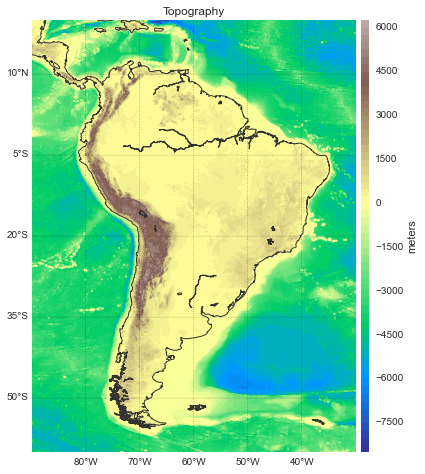

In [31]:
plot_data(lat, lon, topo, shape, cmap='terrain', cblabel='meters')
plt.title('Topography')

## Remove the effect of sediments


## Save the data